In [ ]:

import torch

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import ot
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import TI as spt
from anndata import AnnData

In [ ]:
import StPedf

In [ ]:
random_seed = 2023
StPedf.fix_seed(random_seed)

In [ ]:
# gpu
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# path
data_root = Path(r'F:\StPedf\data\DLPFC\DLPFC')

# sample name
sample_name = '151673'
n_clusters = 5 if sample_name in ['151669', '151670', '151671', '151672'] else 7

In [5]:
adata = sc.read_visium(data_root / sample_name)
adata.var_names_make_unique()

df_meta = pd.read_csv(data_root / sample_name / 'metadata.tsv', sep='\t')
adata.obs['layer_guess'] = df_meta['layer_guess']

In [6]:
adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=20)
sc.pp.filter_genes(adata, min_counts=5)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=2000)

adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

from sklearn.decomposition import PCA  # sklearn PCA is used because PCA in scanpy is not stable. 
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

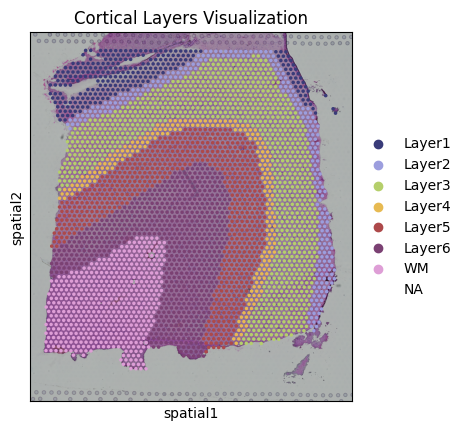

In [ ]:

sc.pl.spatial(
    adata, 
    color="layer_guess", 
    title="Cortical Layers Visualization", 
    legend_loc="right margin", 
    palette="tab20b", 
    size=1 
)

In [ ]:
graph_dict = StPedf.graph_construction(adata, mode='AlphaComplex', alpha_n_neighbors=20)
print(graph_dict)

{'adj_norm': tensor(indices=tensor([[   0,    0,    0,  ..., 3638, 3638, 3638],
                       [   0,  397,  485,  ..., 2506, 3402, 3638]]),
       values=tensor([0.1429, 0.1429, 0.1429,  ..., 0.1429, 0.1429, 0.1429]),
       size=(3639, 3639), nnz=25065, layout=torch.sparse_coo), 'adj_label': tensor(indices=tensor([[   0,    0,    0,  ..., 3638, 3638, 3638],
                       [ 397,  485, 1059,  ..., 2307, 2506, 3402]]),
       values=tensor([1, 1, 1,  ..., 1, 1, 1]),
       size=(3639, 3639), nnz=21426, dtype=torch.int32, layout=torch.sparse_coo), 'norm_value': 0.5008103082279982}


In [ ]:
sedr_net = StPedf.Sedr(adata.obsm['X_pca'], graph_dict, mode='clustering', device=device)
using_dec = True
n_epochs = 100

if using_dec:
    sedr_net.train_with_dec(N=n_epochs)
    sedr_feat, _, _, _, _ = sedr_net.process()
    adata.obsm['SEDR'] = sedr_feat

100%|██████████| 200/200 [00:06<00:00, 29.01it/s]


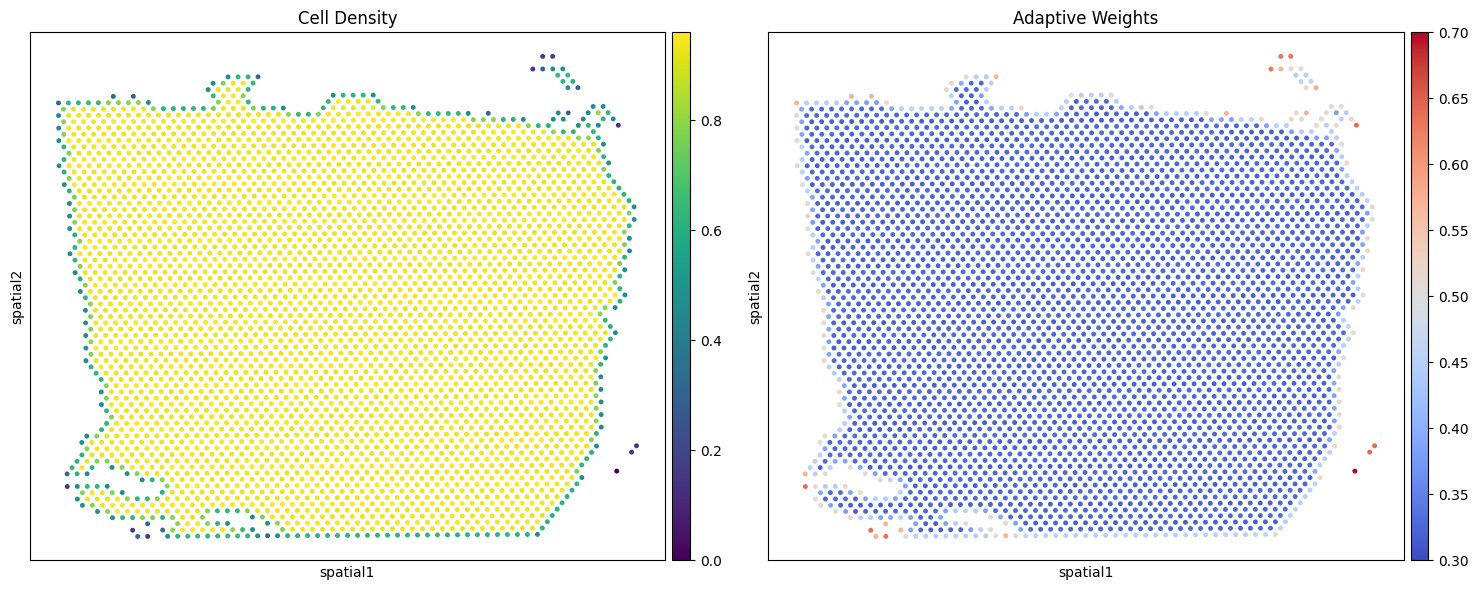

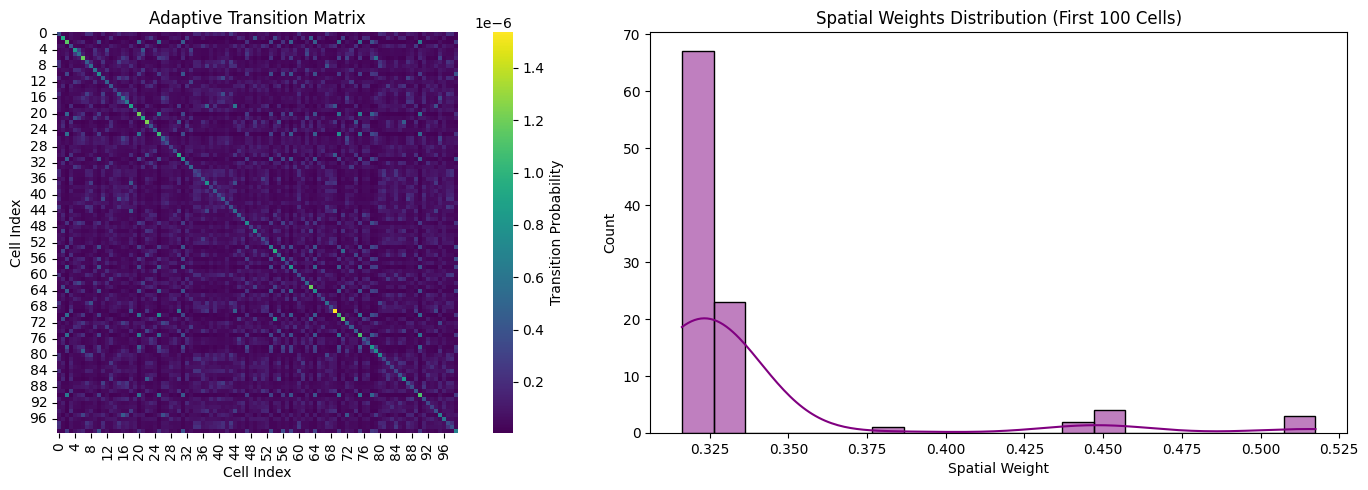

In [ ]:
def construct_adaptive_transition_matrix(
    adata: AnnData,
    sedr_key: str = 'SEDR',
    spatial_key: str = 'spatial',
    reg: float = 0.1,
    base_alpha: float = 0.5,  
    alpha_range: tuple = (0.3, 0.7), 
    spot_size: float = 100 
):
    sedr_emb = adata.obsm[sedr_key]
    spatial_coords = adata.obsm[spatial_key]

    sedr_dist = pairwise_distances(sedr_emb)
    spatial_dist = pairwise_distances(spatial_coords)

    sedr_dist /= sedr_dist.max()
    spatial_dist /= spatial_dist.max()

    from sklearn.neighbors import KernelDensity

    kde = KernelDensity(bandwidth=50, kernel='gaussian')
    kde.fit(spatial_coords)
    density_scores = np.exp(kde.score_samples(spatial_coords))

    density_norm = (density_scores - density_scores.min()) / (
        density_scores.max() - density_scores.min() + 1e-10)
    

    min_alpha, max_alpha = alpha_range
    adaptive_alphas = min_alpha + (max_alpha - min_alpha) * (1 - density_norm)

    adata.obs['cell_density'] = density_norm
    adata.obs['spatial_weight'] = adaptive_alphas

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    sc.pl.embedding(
        adata, 
        basis=spatial_key, 
        color='cell_density', 
        ax=axes[0], 
        show=False, 
        title='Cell Density',
        cmap='viridis',
        size=spot_size
    )
    
    sc.pl.embedding(
        adata, 
        basis=spatial_key, 
        color='spatial_weight', 
        ax=axes[1], 
        show=False, 
        title='Adaptive Weights',
        cmap='coolwarm',
        size=spot_size,
        vmin=min_alpha,
        vmax=max_alpha
    )
    
    plt.tight_layout()
    plt.show()
    
    M = np.zeros_like(spatial_dist)
    for i in range(len(adata)):
        alpha_i = adaptive_alphas[i]
        M[i] = alpha_i * spatial_dist[i] + (1 - alpha_i) * sedr_dist[i]
    
    a = b = np.ones(M.shape[0]) / M.shape[0]
    Gs = ot.sinkhorn(a, b, M, reg=reg)
    
    return Gs


trans = construct_adaptive_transition_matrix(
    adata,
    sedr_key='SEDR',
    spatial_key='spatial',
    reg=0.1, 
    base_alpha=0.5,
    alpha_range=(0.3, 0.7), 
    spot_size=50 
)

adata.obsp["adaptive_trans"] = trans

plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.heatmap(trans[:100, :100], cmap='viridis', square=True, 
            cbar_kws={'label': 'Transition Probability'})
plt.title("Adaptive Transition Matrix")
plt.xlabel("Cell Index")
plt.ylabel("Cell Index")

plt.subplot(122)
sns.histplot(adata.obs['spatial_weight'].iloc[:100], bins=20, 
             kde=True, color='purple')
plt.title("Spatial Weights Distribution (First 100 Cells)")
plt.xlabel("Spatial Weight")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [ ]:

print("簇注释分布：")
print(adata.obs['layer_guess'].value_counts())


簇注释分布：
layer_guess
Layer3    989
Layer6    692
Layer5    673
WM        513
Layer1    273
Layer2    253
Layer4    218
Name: count, dtype: int64


In [ ]:
adata.obs['cluster'] = adata.obs['layer_guess'].astype('category')

print("簇注释分布：")
print(adata.obs['cluster'].value_counts())

簇注释分布：
cluster
Layer3    989
Layer6    692
Layer5    673
WM        513
Layer1    273
Layer2    253
Layer4    218
Name: count, dtype: int64


In [13]:
print("Available obsp keys:", list(adata.obsp.keys()))

Available obsp keys: ['adaptive_trans']


In [ ]:
adata.obsp["trans"] = adata.obsp["adaptive_trans"]

print("Transfer matrix 'trans' added with shape:", adata.obsp["trans"].shape)

Transfer matrix 'trans' added with shape: (3639, 3639)


起始细胞数量: 513


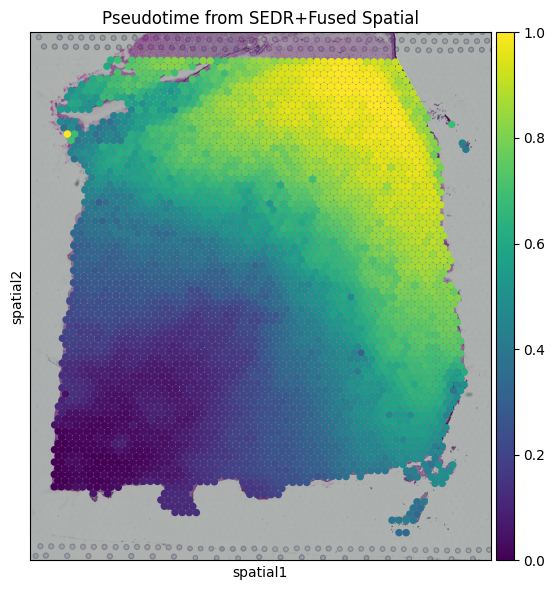

In [ ]:
start_cells = spt.set_start_cells(
    adata,
    select_way='cell_type',
    cell_type='WM',
    n_neigh=30,
    basis='spatial'
)

print(f"起始细胞数量: {len(start_cells)}")

adata.obs["ptime"] = spt.get_ptime(adata, start_cells=start_cells)

fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.spatial(adata, color='ptime', title='Pseudotime from SEDR+Fused Spatial', size=1.5, ax=ax, show=False)
plt.tight_layout()
plt.show()

In [ ]:

adata.obsm['X_spatial'] = adata.obsm['spatial']

Cell velocities stored in 'velocity_spatial'


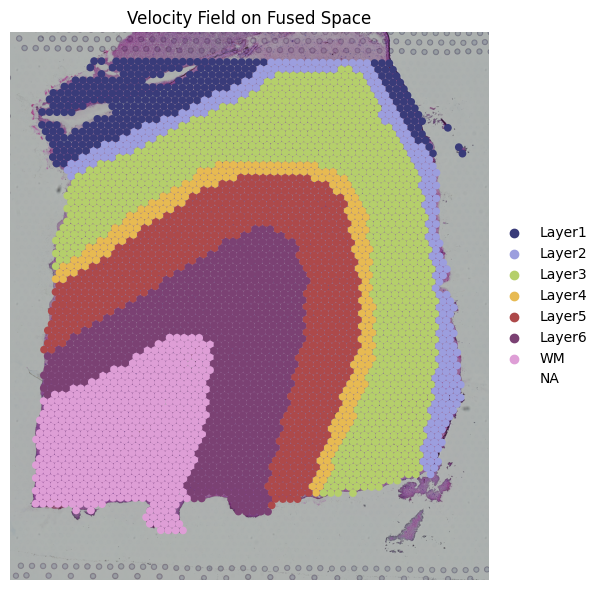

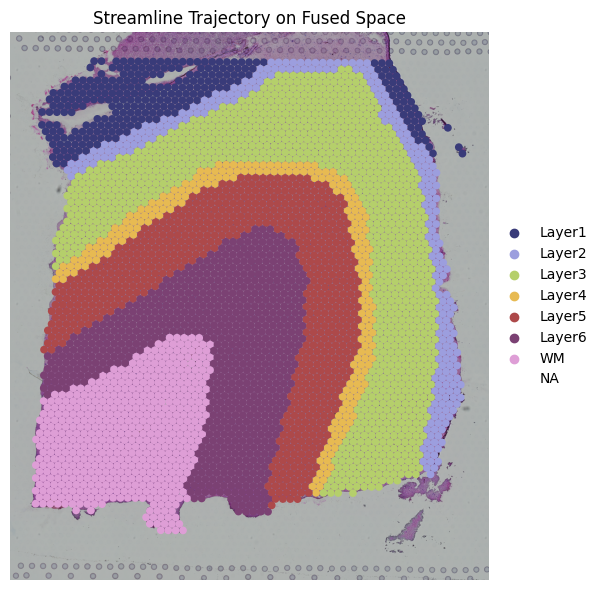

In [ ]:
adata.uns["E_grid"], adata.uns["V_grid"] = spt.get_velocity(adata, basis="spatial", n_neigh_pos=50)

fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.spatial(adata, color='cluster', ax=ax, frameon=False, palette='tab20b', size=1.5, show=False)
ax.quiver(
    adata.uns['E_grid'][0],
    adata.uns['E_grid'][1],
    adata.uns['V_grid'][0],
    adata.uns['V_grid'][1],
    scale=0.008
)
ax.set_title("Velocity Field on Fused Space")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.spatial(adata, color='cluster', ax=ax, frameon=False, palette='tab20b', size=1.5, show=False)
ax.streamplot(
    adata.uns['E_grid'][0],
    adata.uns['E_grid'][1],
    adata.uns['V_grid'][0],
    adata.uns['V_grid'][1],
    density=1.5,
    color='black',
    linewidth=1.5,
    arrowsize=1.2
)
ax.set_title("Streamline Trajectory on Fused Space")
plt.tight_layout()
plt.show()

In [ ]:
VecFld = spt.VectorField(
    adata,
    basis='spatial',
    velocity_key='velocity_spatial',
    n_neighbors=80,
    smooth=1.5  
)

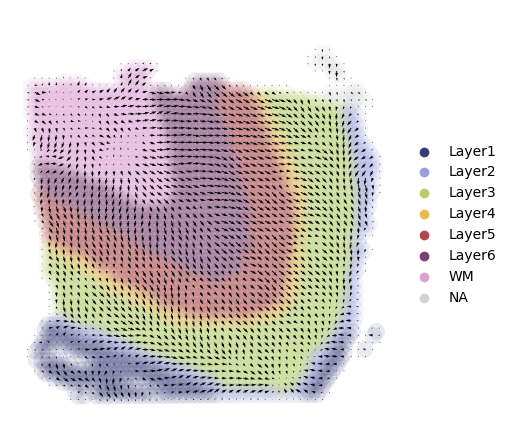

In [19]:
fig, axs = plt.subplots(figsize=(5, 5))
sc.pl.embedding(adata, basis='X_spatial_SparseVFC',show=False,title=' ',color='cluster',ax=axs,frameon=False,palette='tab20b',legend_fontweight='normal',alpha=0.1,size=600)
axs.quiver(adata.uns['E_grid'][0],adata.uns['E_grid'][1],adata.uns['V_grid'][0],adata.uns['V_grid'][1],scale=0.008)

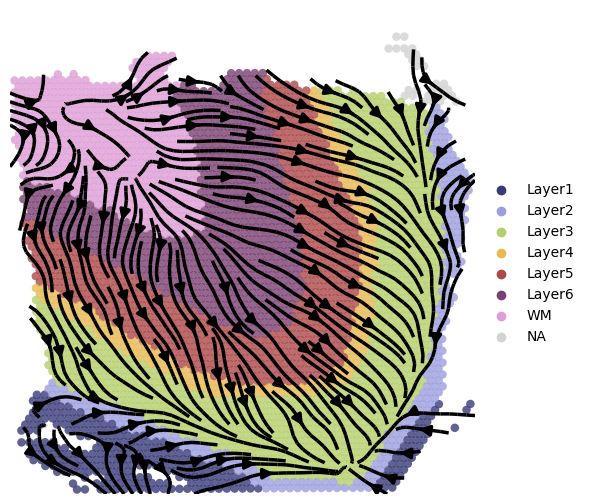

In [20]:
fig,axs=plt.subplots(ncols=1,nrows=1,figsize=(6,6))
ax = sc.pl.embedding(adata,  basis='spatial',show=False,title=' ',color='cluster',ax=axs,frameon=False,palette='tab20b',legend_fontweight='normal',alpha=0.8,size=150)
ax.streamplot(adata.uns['E_grid'][0], adata.uns['E_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1],density=1.8,color='black',linewidth=2.5,arrowsize=1.5)

In [22]:
import gseapy as gp
from gseapy.plot import barplot

In [ ]:

adata.var['corr_with_ptime'] = adata.X.T @ adata.obs['ptime']

top_genes = adata.var.sort_values('corr_with_ptime', key=abs, ascending=False).index[:2000]
gene_exp = adata[:, top_genes].X
gene_list = top_genes.tolist()

In [ ]:

import pandas as pd
gene_corr = []
for gene in adata.var_names:
    corr = np.corrcoef(adata[:, gene].X.flatten(), adata.obs['ptime'].values)[0, 1]
    gene_corr.append((gene, corr))

gene_corr_sorted = sorted(gene_corr, key=lambda x: abs(x[1]), reverse=True)

ranked_genes = [item[0] for item in gene_corr_sorted]
corr_values = [item[1] for item in gene_corr_sorted]
gene_rank = pd.Series(corr_values, index=ranked_genes)

In [ ]:

prerank_res = gp.prerank(
    rnk=gene_rank,
    gene_sets='GO_Biological_Process_2021',  
    max_size=500,
    permutation_num=1000,
    outdir=f'./prerank_gsea_results_{sample_name}',
    verbose=True
)

2025-09-06 14:33:19,711 [INFO] Parsing data files for GSEA.............................
2025-09-06 14:33:26,409 [INFO] Downloading and generating Enrichr library gene sets......
2025-09-06 14:33:46,233 [INFO] 5757 gene_sets have been filtered out when max_size=500 and min_size=15
2025-09-06 14:33:46,234 [INFO] 0279 gene_sets used for further statistical testing.....
2025-09-06 14:33:46,235 [INFO] Start to run GSEA...Might take a while..................
2025-09-06 14:33:56,350 [INFO] Congratulations. GSEApy runs successfully................



富集结果列名: ['Name', 'Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'FWER p-val', 'Tag %', 'Gene %', 'Lead_genes']
FDR q-val的数据类型: object
处理后剩余基因集数量: 10


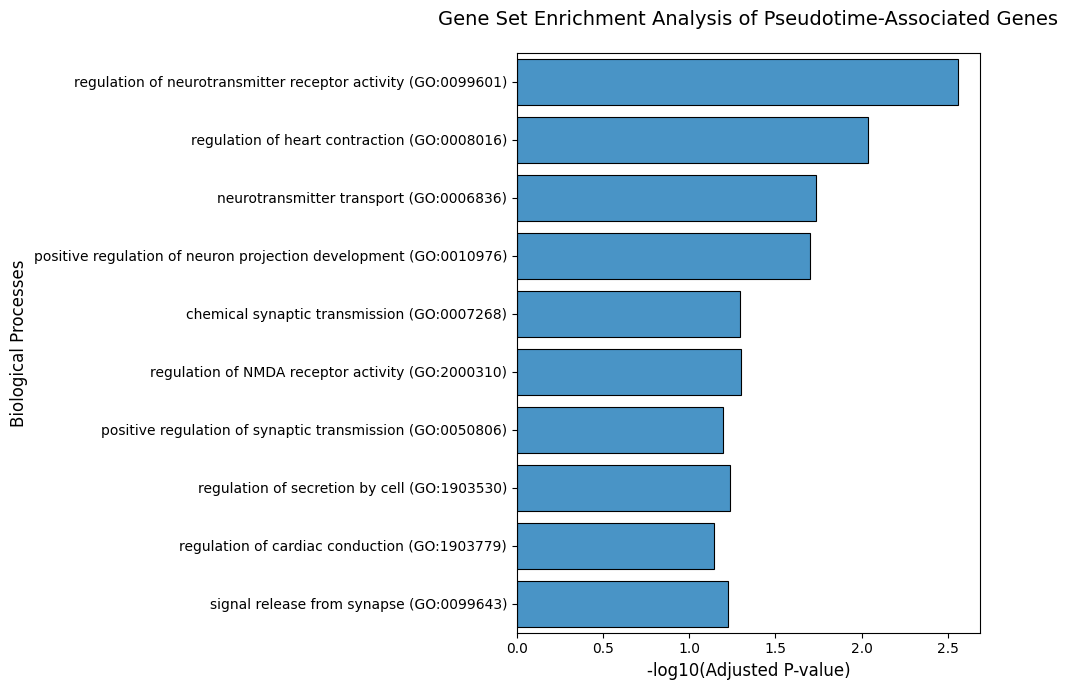

In [ ]:

enrich_df = prerank_res.res2d.copy()

print("富集结果列名:", enrich_df.columns.tolist())
print("FDR q-val的数据类型:", enrich_df['FDR q-val'].dtype)

enrich_df['FDR q-val'] = pd.to_numeric(enrich_df['FDR q-val'], errors='coerce')

enrich_df = enrich_df.dropna(subset=['FDR q-val'])

enrich_df = enrich_df[~enrich_df['Term'].str.contains('regulation of cation channel activity')]

enrich_df['-log10(FDR)'] = -np.log10(enrich_df['FDR q-val'])

enrich_top10 = enrich_df.sort_values('NES', ascending=False).head(10)

print("处理后剩余基因集数量:", len(enrich_top10))

plt.figure(figsize=(10, 7))

sns.barplot(
    data=enrich_top10,
    y='Term',  
    x='-log10(FDR)', 
    color='#3498db',   
    edgecolor='black',
    linewidth=0.8
)

plt.title('Gene Set Enrichment Analysis of Pseudotime-Associated Genes', fontsize=14, pad=20)
plt.xlabel('-log10(Adjusted P-value)', fontsize=12)
plt.ylabel('Biological Processes', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()

plt.savefig(f'simplified_gsea_plot_{sample_name}.png', dpi=300, bbox_inches='tight')
plt.show()